<a href="https://colab.research.google.com/github/tselest/ML_DL_projects/blob/main/Malaria_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
import os
import random
import pickle

import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.image import imread

from sklearn.model_selection import  train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix,roc_curve,auc

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [88]:
!pip install visualkeras
# For visualizing the created model

     |████████████████████████████████| 798kB 11.4MB/s 


In [89]:
import visualkeras

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Malaria Dataset

The malaria image dataset is obtained from the National Library of Medicine hosted by Lister Hill National Center for Biomedical Communications, USA. The training dataset consists of 27,558 images in total, equally divided into classes ‘parasitized’ and ‘uninfected’. The test dataset consists of 2600 images in total, equally divided into classes ‘parasitized’ and ‘uninfected’. All the images are less than 20 KB in size and are of varied dimensions. 

Available from [Kaggle](https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria)

Available from [NIH](https://lhncbc.nlm.nih.gov/LHC-publications/pubs/MalariaDatasets.html)

In [3]:
cells_dir = '/content/drive/MyDrive/Colab datasets/cell_images'

TRAIN_PATH = os.path.join(cells_dir, 'train/')
TEST_PATH = os.path.join(cells_dir, 'test/')

In [4]:
inf_cells = random.sample(os.listdir(os.path.join(TRAIN_PATH, 'parasitized/')),16)
uninf_cells = random.sample(os.listdir(os.path.join(TRAIN_PATH, 'uninfected/')),16)

## 2. Data Exploration

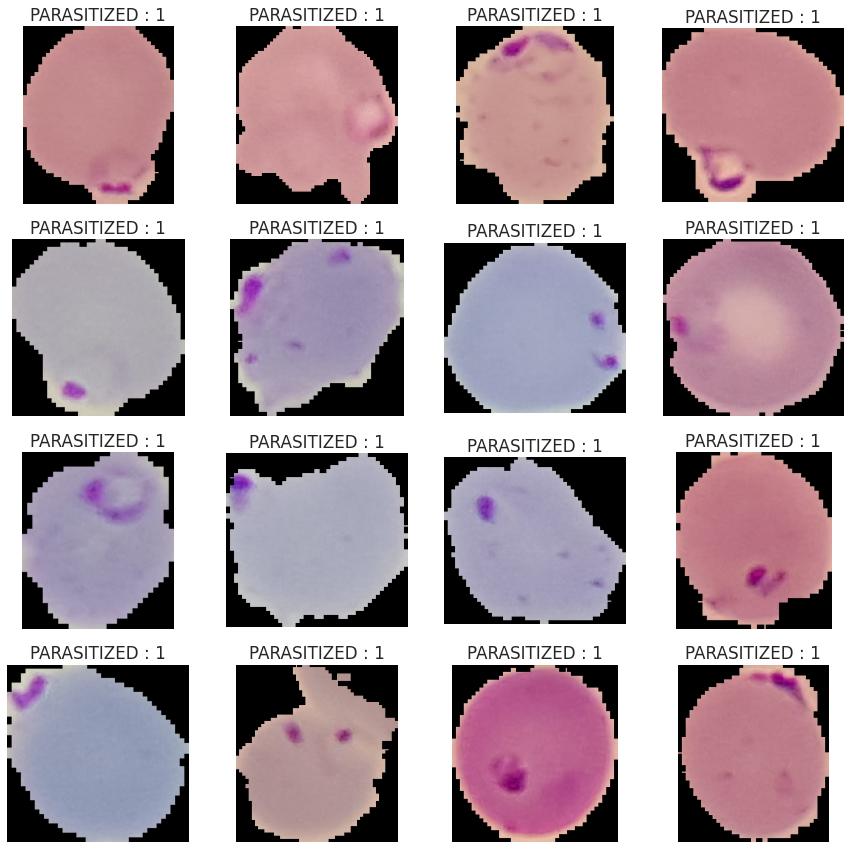

In [58]:
plt.figure(figsize=(15, 15)) 

for i in range(1, len(inf_cells)+1):
    row = i
    image = plt.imread(os.path.join(TRAIN_PATH,'parasitized/') + inf_cells[i-1])
    plt.subplot(4, 4, row)
    plt.axis("off")
    plt.imshow(image)
    plt.title('PARASITIZED : 1')
    
plt.show()

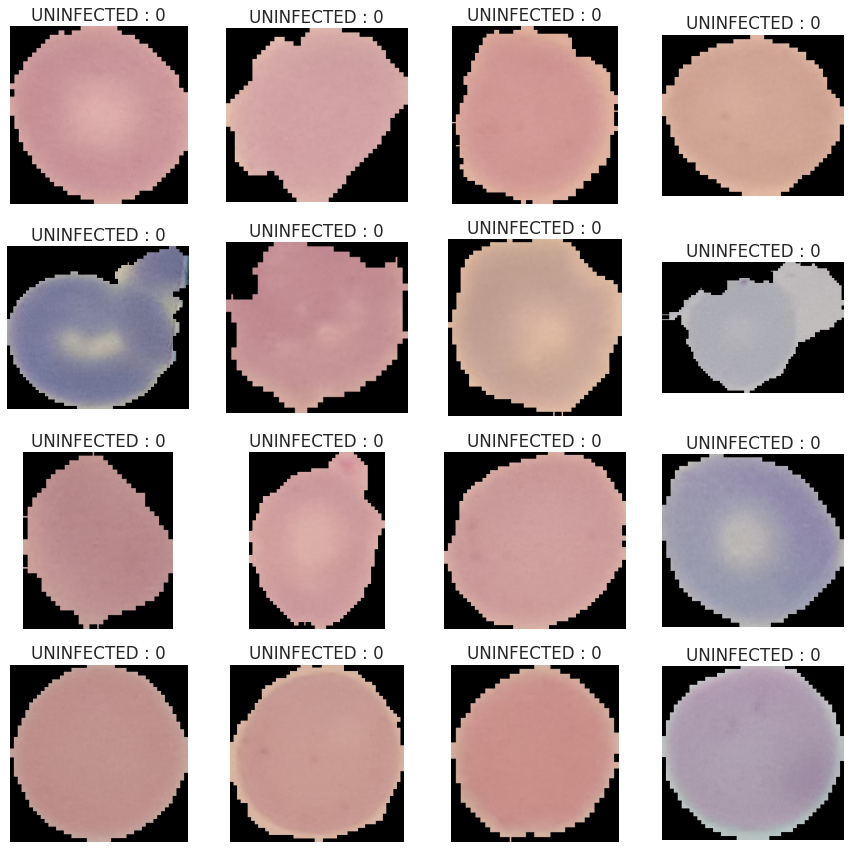

In [59]:
plt.figure(figsize=(15, 15)) 

for i in range(1, len(uninf_cells)+1):
    row = i
    image = plt.imread(os.path.join(TRAIN_PATH,'uninfected/') + uninf_cells[i-1])
    plt.subplot(4, 4, row)
    plt.axis("off")
    plt.imshow(image)
    plt.title('UNINFECTED : 0')

plt.show()

In [7]:
print(f"The training folders contain {len(os.listdir(TRAIN_PATH +'parasitized'))} parasitized images and {len(os.listdir(TRAIN_PATH +'uninfected'))} uninfected images")
print(f"The test folders contain {len(os.listdir(TEST_PATH +'parasitized'))} parasitized images and {len(os.listdir(TEST_PATH +'uninfected'))} uninfected images")

The training folders contain 12490 parasitized images and 12480 uninfected images
The test folders contain 1300 parasitized images and 1300 uninfected images


In [9]:
dim1 = []
dim2 = []

for img_fname in os.listdir(TEST_PATH + 'uninfected'):

  img = imread(TEST_PATH + 'uninfected/' + img_fname)
  d1, d2, colors = img.shape
  dim1.append(d1)
  dim2.append(d2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


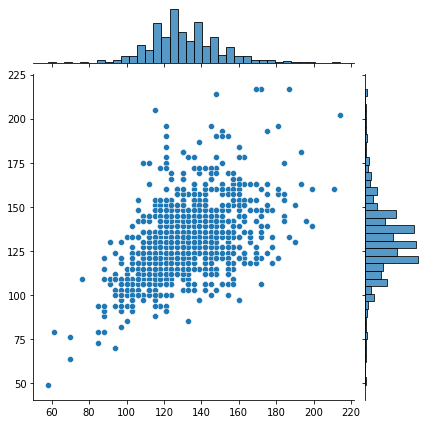

In [10]:
# plotting the different dimensions of the images

sns.jointplot(dim1, dim2)

## 3. Data augmentation

Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, the model will not see the exact same picture twice. This helps to expose the model to more aspects of the data and generalize better.

In [36]:
batch_size = 16

train_datagen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1,
                             zoom_range=0.1,
                             horizontal_flip=True,
                             fill_mode='nearest',
                             rescale=1./255,
                             )

test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(TRAIN_PATH, 
                                              target_size=(130,130),
                                              color_mode = 'rgb',
                                              class_mode = "binary",
                                              batch_size=batch_size,
                                              shuffle=True)


test_generator = test_datagen.flow_from_directory(TEST_PATH,    
                                             target_size=(130,130),
                                             color_mode = 'rgb',
                                             class_mode = "binary",
                                             batch_size=batch_size,
                                             shuffle = False
                                             )


Found 24968 images belonging to 2 classes.
Found 2600 images belonging to 2 classes.


In [18]:
TRAIN_PATH

'/content/drive/MyDrive/Colab datasets/cell_images/train/'

In [ ]:
/content/drive/MyDrive/Colab datasets/cell_images/train/uninfected

In [24]:
par_train = '/content/drive/MyDrive/Colab datasets/cell_images/train/parasitized/' + os.listdir(os.path.join(TRAIN_PATH, 'parasitized/'))[0]


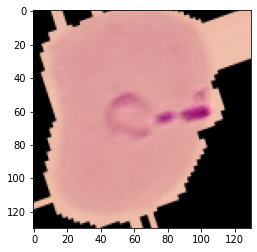

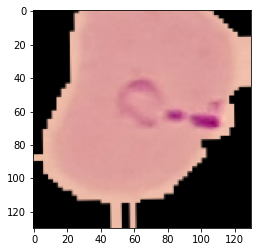

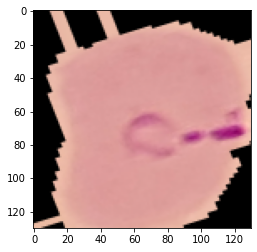

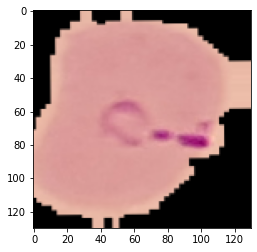

In [25]:

img = image.load_img(par_train, target_size=(130,130))

x = image.img_to_array(img)

x = x.reshape((1,) + x.shape)

i=0
for batch in train_datagen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot=plt.imshow(image.array_to_img(batch[0]))
  i += 1
  if i%4==0:
    break

plt.show()

## 4. Convolutional neural network

In [66]:
input_shape = (130, 130, 3)

model = Sequential()

model.add(Conv2D(filters=128, kernel_size=(3,3),input_shape=input_shape, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

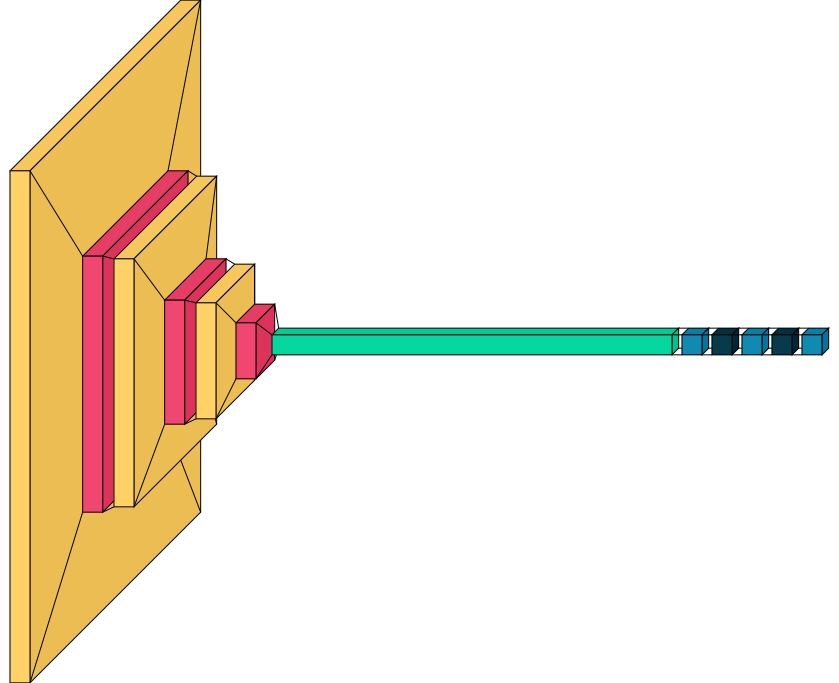

In [92]:
visualkeras.layered_view(model)

In [67]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 128, 128, 128)     3584      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 62, 62, 64)        73792     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 29, 29, 32)        18464     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 6272)             

In [68]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [69]:
train_generator.class_indices

{'parasitized': 0, 'uninfected': 1}

In [70]:
history = model.fit_generator(train_generator, 
                              validation_data=test_generator,
                              steps_per_epoch = len(train_generator),
                              validation_steps=len(test_generator),
                              epochs=20, 
                              callbacks=[early_stop]
                              )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
781/781 [==============================] - 6100s 8s/step - loss: 0.6873 - accuracy: 0.5332 - val_loss: 0.2256 - val_accuracy: 0.9208
Epoch 2/20
781/781 [==============================] - 198s 253ms/step - loss: 0.2243 - accuracy: 0.9311 - val_loss: 0.1830 - val_accuracy: 0.9454
Epoch 3/20
781/781 [==============================] - 195s 249ms/step - loss: 0.1840 - accuracy: 0.9461 - val_loss: 0.1548 - val_accuracy: 0.9531
Epoch 4/20
781/781 [==============================] - 194s 249ms/step - loss: 0.1713 - accuracy: 0.9496 - val_loss: 0.1780 - val_accuracy: 0.9485
Epoch 5/20
781/781 [==============================] - 194s 248ms/step - loss: 0.1629 - accuracy: 0.9521 - val_loss: 0.1488 - val_accuracy: 0.9523
Epoch 6/20
781/781 [==============================] - 194s 249ms/step - loss: 0.1663 - accuracy: 0.9491 - val_loss: 0.1490 - val_accuracy: 0.9558
Epoch 7/20
781/781 [==============================] - 193s 247ms/step - loss: 0.1654 - accuracy: 0.9520 - val_loss: 0.1383 - v

In [71]:
model.save('/content/drive/MyDrive/Colab Notebooks/my_malaria_detector.h5')

In [42]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/my_malaria_detector.h5')

In [72]:
model.evaluate_generator(test_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.13834477961063385, 0.9576923251152039]

In [85]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

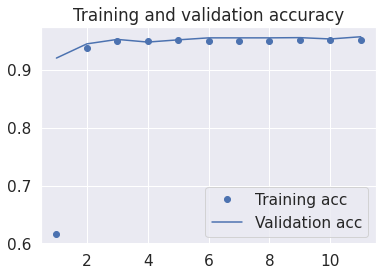

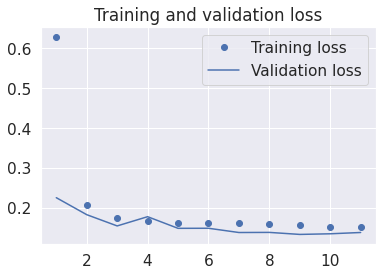

In [86]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()



In [73]:
predictions = model.predict_generator(test_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [74]:
preds = predictions > 0.5

In [75]:
print(classification_report(test_generator.classes, preds))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1300
           1       0.95      0.97      0.96      1300

    accuracy                           0.96      2600
   macro avg       0.96      0.96      0.96      2600
weighted avg       0.96      0.96      0.96      2600



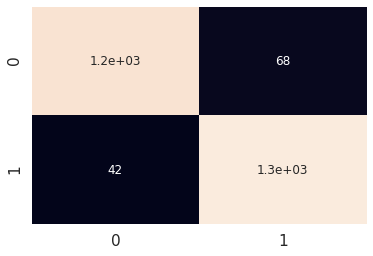

In [76]:
conf = confusion_matrix(test_generator.classes, preds)
sns.set(font_scale=1.4) 
sns.heatmap(conf, annot=True, annot_kws={"size": 12}, cbar=False)

Found 2600 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


82/82 [==============================] - 8s 92ms/step


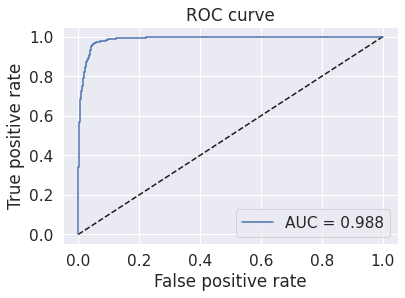

In [77]:
roc_val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(TEST_PATH,
                                                                                  target_size=(130,130),
                                                                                  batch_size=batch_size,
                                                                                  class_mode='binary',
                                                                                  shuffle=False)
predictions = model.predict_generator(roc_val_generator, steps=len(roc_val_generator), verbose=1)
false_positive_rate, true_positive_rate, threshold = roc_curve(roc_val_generator.classes, predictions)
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [81]:
# predict on a single image

test_img = '/content/drive/MyDrive/Colab datasets/cell_images/test/uninfected/C100P61ThinF_IMG_20150918_145042_cell_33.png'

img = image.load_img(test_img, target_size=input_shape)

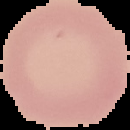

In [87]:
img

In [82]:
img_arr_ = image.img_to_array(img)
img_arr = np.expand_dims(img_arr_, axis=0)

In [83]:
model.predict(img_arr) # CORRECT!

array([[1.]], dtype=float32)

In [94]:
pickle_out = open("/content/drive/MyDrive/Colab Notebooks/predictions.pickle","wb")
pickle.dump(predictions, pickle_out)
pickle_out.close()

## 5. Next Steps

**Transfer Learning** by using a pretrained convnet, such as VGG16.

**Hyperparameters tuning** either manually or by using a package like keras-tuner.